# Automate SQL Database Queries with LLM

# Table of Contents

1. [Introduction](#introduction)
2. [Load Libraries](#load-libraries)
3. [Setup AI and Logging](#setup-ai-and-logging)
4. [Connect to a SQL Database](#connect-to-a-sql-database)
5. [Create The Agent](#create-the-agent)
6. [Run the Agent](#run-the-agent)
7. [Response](#response)
    1. [SQL Query Code](#sql-query-code)
    2. [Pandas Data Frame From SQL Query](#pandas-data-frame-from-sql-query)
    3. [Python Pipeline Function](#python-pipeline-function)
    4. [Storage Location](#storage-location)

### Load Libraries

In [18]:
import sys
sys.path.append('..')

In [19]:
# * Libraries
import pandas as pd, sqlalchemy as sql, os
from pprint import pprint

from langchain_openai import ChatOpenAI
from DAPCOR.agents import SQLDatabaseAgent

### Setup AI and Logging

This section of code sets up the LLM inputs and the logging information. Logging is used to store AI-generated code and files. 

*Important Note:* This example uses OpenAI's API. But any LLM can be used such as Anthropic or local LLMs with Ollama.

In [20]:
# load API and create llm object
MODEL = "gpt-4o-mini"
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

llm = ChatOpenAI(model = MODEL)
llm

ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x00000146274DA6C0>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x00000146274CD670>, root_client=<openai.OpenAI object at 0x00000146274CC110>, root_async_client=<openai.AsyncOpenAI object at 0x00000146274CC260>, model_name='gpt-4o-mini', model_kwargs={}, openai_api_key=SecretStr('**********'))

### Connect to a SQL Database

Next, let's connect to the FCCU SQL database. We will need to use a `sqlalchemy` connection to use the SQL Database Agent.

In [21]:
# Create the engine with the correct path
db_path = os.path.join("..", "data", "FCCU.db")
sql_engine = sql.create_engine(f"sqlite:///{db_path}")
conn = sql_engine.connect()

In [22]:
# manually check tables in the database
sql_query = "SELECT name FROM sqlite_master WHERE type='table';"
pd.read_sql(sql_query, conn)

,name
0,historical_data


In [23]:
# manually read data from the historical_data table
sql_query = "SELECT * FROM historical_data;"
historical_data = pd.read_sql(sql_query, conn)
historical_data.head()

,timestamp,Fresh feed flow,Ambient temperature,Feed temperature,Reactor pressure,Regenerator pressure,Furnace temperature,Reactor feed temperature,Regenerator temperature,Catalyst level,...,Reactor temperature controller valve opening,Ampearage combustion air blower,Ampearage wet gas blower,Furnace fuel flowrate,Combustion air flowrate,LPG flowrate,Light cycle oil flowrate,Reflux flowrate,Overhead fractionator temperature,Fractionator temperature controller valve opening
0,2025-01-01 00:00:00,165.00,75.014,460.90,34.4,28.0,1564.1,616.00,1250.0,29.684,...,45.302,277.72,198.71,1990.5,3734.7,2933.9,1643.4,2945.5,310.71,49.530
1,2025-01-01 00:01:00,165.06,75.043,460.75,34.4,28.0,1565.3,615.99,1250.0,29.673,...,45.312,277.75,198.75,1993.6,3734.8,2934.7,1643.3,2945.8,310.72,49.532
2,2025-01-01 00:02:00,165.02,75.045,460.88,34.4,28.0,1564.3,616.00,1250.0,29.679,...,45.306,277.76,198.76,1991.1,3734.9,2934.8,1643.3,2946.0,310.73,49.535
3,2025-01-01 00:03:00,164.96,75.044,460.77,34.4,28.0,1564.6,616.00,1250.0,29.688,...,45.298,277.76,198.76,1991.8,3734.8,2934.8,1643.3,2946.1,310.73,49.536
4,2025-01-01 00:04:00,164.92,75.049,460.84,34.4,28.0,1563.9,616.00,1250.0,29.696,...,45.291,277.75,198.77,1990.2,3734.5,2934.9,1643.3,2946.1,310.74,49.536


### Create The Agent

Run this code to create the agent with `SQLDatabaseAgent()`.

The only required parameters are `model` and `connection`. 

- `model` is the LLM model that you want to use.
- `connection` is the sqlalchemy connection to the SQL database.

Other parameters included in this demo are:

- `n_samples`: The number of samples for each table x column to share with the LLM. Reduce this number for large databases to prevent LLM Max Token errors.
- `log`: Set up logging the SQL DB agent's pipeline function
- `log_path`: The directory to save the SQL DB agent's pipeline function
- `bypass_explain_code`: Dynamically bypass the explain code step in the LangGraph DAG. This is useful to speed up response time when you don't need to see the explain code.
- `bypass_recommended_steps`: Dynamically bypass the recommended steps in the LangGraph DAG. This is useful to speed up response time when you don't need to see the recommended steps.

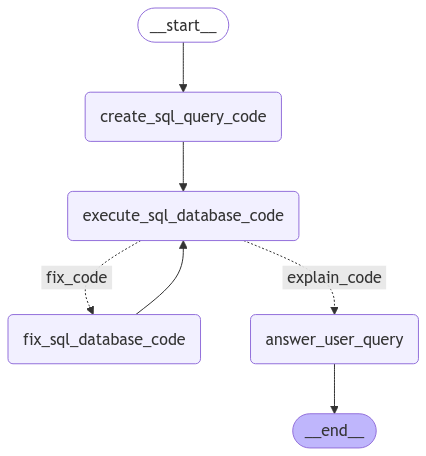

In [24]:
# Make the agent
LOG      = True
LOG_PATH = os.path.join("..", "logs/")

sql_agent = SQLDatabaseAgent(
    model = llm, 
    connection=conn, 
    n_samples=1, # Needed for large databases to avoid token limits
    log=LOG, 
    log_path=LOG_PATH,
    bypass_explain_code=False,
    bypass_recommended_steps=True,
)

sql_agent

## Run the Agent

The main inputs to the SQL DB Agent are:

- **user_instructions**: What actions you'd like to take on the SQL database query. 
- **max_retries**: Used to limit the number of attempts to fix the SQL and Python code generated by the agent. Set this to 3 to limit to 3 attempts. 
- **retry_count**: Set this to 0. 

In [25]:
sql_agent.invoke_agent(
    # user_instructions="What is the daily average of the fresh feed flow and furnace temperature?",
    user_instructions="What is the maximum furnace temperature?",
    max_retries=3,
    retry_count=0,
)

---SQL DATABASE AGENT----
    * CREATE SQL QUERY CODE
    * CREATE PYTHON FUNCTION TO RUN SQL CODE
      File saved to: ..\logs/sql_database.py
    * EXECUTING AGENT CODE ON SQL CONNECTION
    * GENERATE USER ANSWER


### Response

The response produced contains everything we need to understand the data cleaning decisions made and get the cleaned dataset. 

In [26]:
response = sql_agent.get_response()
list(response.keys())

['messages',
 'user_instructions',
 'data_sql',
 'user_answer',
 'all_sql_database_summary',
 'sql_query_code',
 'sql_database_function',
 'sql_database_function_path',
 'sql_database_function_file_name',
 'sql_database_function_name',
 'sql_database_error',
 'max_retries',
 'retry_count']

In [27]:
sql_agent.response["user_answer"]

'The maximum furnace temperature is 1593.2 degrees.'

#### SQL Query Code

In [28]:
sql_agent.get_sql_query_code(markdown=True)

```sql
SELECT MAX("Furnace temperature") AS max_furnace_temperature
FROM historical_data;
```

#### Pandas Data Frame From SQL Query

In [29]:
sql_agent.get_data_sql()

,max_furnace_temperature
0,1593.2


#### Python Pipeline Function

In [30]:
sql_agent.get_sql_database_function(markdown=True)

```python
# Disclaimer: This function was generated by AI. Please review before using.
# Agent Name: sql_database_agent
# Time Created: 2025-02-02 00:56:19


def sql_database_pipeline(connection):
    import pandas as pd
    import sqlalchemy as sql
    
    # Create a connection if needed
    is_engine = isinstance(connection, sql.engine.base.Engine)
    conn = connection.connect() if is_engine else connection

    sql_query = '''
    SELECT MAX("Furnace temperature") AS max_furnace_temperature
FROM historical_data;
    '''
    
    return pd.read_sql(sql_query, connection)
    
```